# 3.2

# Importing Files and Loading the Data sets

In [23]:
import os
import tarfile
import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy import stats
from sklearn.svm import SVR
from scipy.stats import expon, reciprocal
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score

In [24]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [25]:
fetch_housing_data()

In [26]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [27]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [28]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [29]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

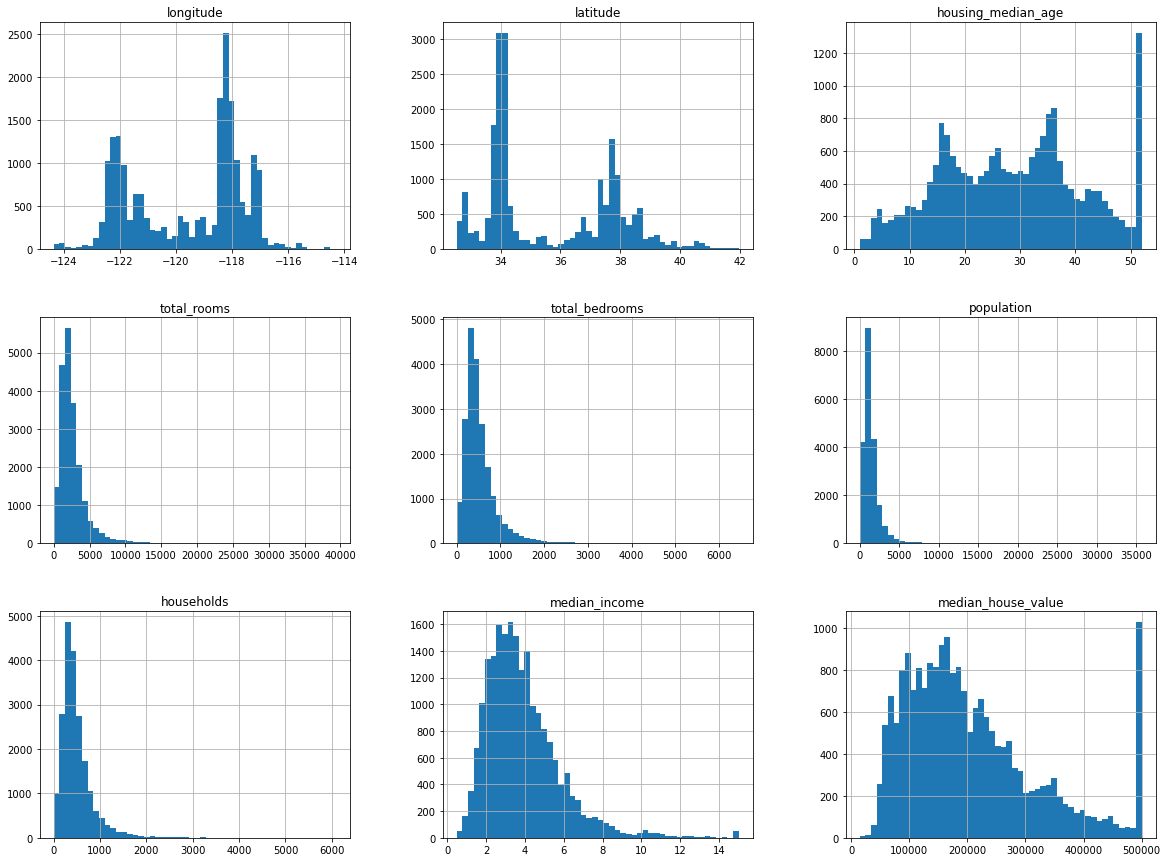

In [30]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Splitting the data 

In [31]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [32]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [33]:
len(test_set)

4128

In [34]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [35]:
housing_with_id = housing.reset_index()  
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [36]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [37]:
housing_with_id

index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
2          2    -122.24     37.85                52.0       1467.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1              1106.0      2401.0      1138.0         8.3014   
2               190.0       496.0       177.0         7.2574   
3               235.0       558.0       219.0         5.6431   
4               280.0       565.0       259.0         3.8462   
...               ...         ...         ...            ...   
20635           374.0       845.0       330.0         1.5603   
20636           150.0       356.0       114.0         2.5568   
20637           485.0      1007.0       433.0         1.7000   
20638           409.0       741.0       349.0         1.8672   
20639           616.0      1387.0       530.0         2.3886   

       median_house_value ocean_proximity         id  
0                452600.0        NEAR BAY -122192.12  
1                358500.0        NEAR BAY -122182.14  
2                352100.0        NEAR BAY -122202.15  
3                341300.0        NEAR BAY -122212.15  
4                342200.0        NEAR BAY -122212.15  
...                   ...             ...        ...  
20635             78100.0          INLAND -121050.52  
20636             77100.0          INLAND -121170.51  
20637             92300.0          INLAND -121180.57  
20638             84700.0          INLAND -121280.57  
20639             89400.0          INLAND -121200.63  

[20640 rows x 12 columns]

In [38]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [39]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

In [40]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [41]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [42]:
# mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host 0.0.0.0 --port 5000
remote_server_uri = "http://127.0.0.1:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [43]:
mlflow.tracking.get_tracking_uri()

'http://127.0.0.1:5000'

In [44]:
exp_name = "Housing-Prediction"
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='Housing-Prediction', tags={}>

In [45]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [46]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [47]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 10

In [48]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039971  0.040213      0.973236      90.364964
2  0.318847    0.318798  0.324370      1.732260      89.984805
3  0.350581    0.350533  0.358527      2.266446      89.986180
4  0.176308    0.176357  0.167393     -5.056334      90.027480
5  0.114438    0.114341  0.109496     -4.318374      89.915326

In [49]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Data cleaning 

In [50]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [51]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [52]:
housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  households  median_income ocean_proximity  
12655      2237.0       706.0         2.1736          INLAND  
15502      2015.0       768.0         6.3373      NEAR OCEAN  
2908        667.0       300.0         2.8750          INLAND  
14053       898.0       483.0         2.2264      NEAR OCEAN  
20496      1837.0       580.0         4.4964       <1H OCEAN  
...           ...         ...            ...             ...  
15174      2026.0      1001.0         5.0900       <1H OCEAN  
12661      4769.0      1418.0         2.8139          INLAND  
19263       458.0       172.0         3.1797       <1H OCEAN  
19140      1208.0       501.0         4.1964       <1H OCEAN  
19773       625.0       197.0         3.1319          INLAND  

[16512 rows x 9 columns]

In [53]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [54]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [55]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [56]:
imputer = SimpleImputer(strategy="median")

In [57]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [58]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [59]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [60]:
X = imputer.transform(housing_num)

In [61]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [62]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  
12655      2237.0       706.0         2.1736  
15502      2015.0       768.0         6.3373  
2908        667.0       300.0         2.8750  
14053       898.0       483.0         2.2264  
20496      1837.0       580.0         4.4964

In [63]:
housing_cat = housing[["ocean_proximity"]]

In [64]:
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

In [65]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [66]:
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

In [67]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [68]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [69]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [70]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [71]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [72]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
12655   -121.46    38.52               29.0      3873.0          797.0   
15502   -117.23    33.09                7.0      5320.0          855.0   
2908    -119.04    35.37               44.0      1618.0          310.0   
14053   -117.13    32.75               24.0      1877.0          519.0   
20496    -118.7    34.28               27.0      3536.0          646.0   

      population households median_income ocean_proximity rooms_per_household  \
12655     2237.0      706.0        2.1736          INLAND            5.485836   
15502     2015.0      768.0        6.3373      NEAR OCEAN            6.927083   
2908       667.0      300.0         2.875          INLAND            5.393333   
14053      898.0      483.0        2.2264      NEAR OCEAN            3.886128   
20496     1837.0      580.0        4.4964       <1H OCEAN            6.096552   

      population_per_household  
12655                 3.168555  
15502                 2.623698  
2908                  2.223333  
14053                 1.859213  
20496                 3.167241

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def My_Pipeline1():
    with mlflow.start_run(run_name='Pipeline1', nested=True) as pipe2_run:
        num_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy="median")),
                ('attribs_adder', CombinedAttributesAdder()),
                ('std_scaler', StandardScaler()),
                ])

        return(num_pipeline.fit_transform(housing_num),num_pipeline)

In [74]:
housing_num_tr,num_pipeline=My_Pipeline1()

In [75]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [76]:
def My_Pipeline2():
    with mlflow.start_run(run_name='Pipeline2', nested=True) as pipe2_run:  
        num_attribs = list(housing_num)
        cat_attribs = ["ocean_proximity"]

        full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", OneHotEncoder(), cat_attribs),
            ])

        return(full_pipeline.fit_transform(housing),full_pipeline)

In [77]:
housing_prepared,full_pipeline=My_Pipeline2()

In [78]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# Starting ML Flow Server

In [79]:
# mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host 0.0.0.0 --port 5000
remote_server_uri = "http://127.0.0.1:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [80]:
mlflow.tracking.get_tracking_uri()

'http://127.0.0.1:5000'

In [81]:
exp_name = "Housing-Prediction"
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='Housing-Prediction', tags={}>

# ML FLow Script for Model-Training

In [82]:
with mlflow.start_run(run_name='Hosuing Prediction') as main_run:
    My_Pipeline1()
    My_Pipeline2()
    with mlflow.start_run(run_name="Linear Regression", nested=True) as lin_run:

        print("\nLinear Regression")

        lin_reg = LinearRegression()
        lin_reg.fit(housing_prepared, housing_labels)

        housing_predictions = lin_reg.predict(housing_prepared)


        lin_mse = mean_squared_error(housing_labels, housing_predictions)
        lin_rmse = np.sqrt(lin_mse)


        lin_mae = mean_absolute_error(housing_labels, housing_predictions)


        r2 = r2_score(housing_labels, housing_predictions)

        print("Root Mean Squared Error:", lin_rmse)
        print("Mean Absolute Error:", lin_mae)
        print("R2: %s" % r2)


        lin_scores = cross_val_score(
            lin_reg,
            housing_prepared,
            housing_labels,
            scoring="neg_mean_squared_error",
            cv=10,
        )
        lin_rmse_scores = np.sqrt(-lin_scores)

        def display_scores(scores):
            print("Scores:", scores)
            print("Mean:", scores.mean())
            print("Standard deviation:", scores.std())

        display_scores(lin_rmse_scores)

        mlflow.log_param("Scores", lin_rmse_scores)
        mlflow.log_metric("Mean", lin_rmse_scores.mean())
        mlflow.log_metric("RMSE", lin_rmse)
        mlflow.log_metric("MAE", lin_mae)
        mlflow.log_metric("Standard deviation", lin_rmse_scores.std())
        mlflow.log_metric("R2", r2)

        mlflow.sklearn.log_model(lin_reg, "Linear Regression Model")

    with mlflow.start_run(run_name="Decision Tree Regressor", nested=True) as tree_run:

        print("\nDecision Tree Regressor")

        tree_reg = DecisionTreeRegressor(random_state=42)
        tree_reg.fit(housing_prepared, housing_labels)

        housing_predictions = tree_reg.predict(housing_prepared)

        tree_mse = mean_squared_error(housing_labels, housing_predictions)
        tree_rmse = np.sqrt(tree_mse)

        tree_mae = mean_absolute_error(housing_labels, housing_predictions)

        r2 = r2_score(housing_labels, housing_predictions)

        print("Mean Squared Error:", tree_rmse)
        print("Mean Absolute Error:", tree_mae)
        print("R2: %s" % r2)

        scores = cross_val_score(
            tree_reg,
            housing_prepared,
            housing_labels,
            scoring="neg_mean_squared_error",
            cv=10,
        )
        tree_rmse_scores = np.sqrt(-scores)

        def display_scores(scores):
            print("Scores:", scores)
            print("Mean:", scores.mean())
            print("Standard deviation:", scores.std())

        display_scores(tree_rmse_scores)

        mlflow.log_param("Scores", tree_rmse_scores)
        mlflow.log_metric("Mean", tree_rmse_scores.mean())
        mlflow.log_metric("RMSE", tree_rmse)
        mlflow.log_metric("MAE", tree_mae)
        mlflow.log_metric("Standard deviation", tree_rmse_scores.std())
        mlflow.log_metric("R2", r2)

        mlflow.sklearn.log_model(tree_reg, "Decision Tree Model")

    with mlflow.start_run(run_name="Random Forest Regressor", nested=True) as forest_run:

        print("\nRandom Forest Regressor")

        forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
        forest_reg.fit(housing_prepared, housing_labels)

        housing_predictions = forest_reg.predict(housing_prepared)

        forest_mse = mean_squared_error(housing_labels, housing_predictions)
        forest_rmse = np.sqrt(forest_mse)

        forest_mae = mean_absolute_error(housing_labels, housing_predictions)
        
        r2 = r2_score(housing_labels, housing_predictions)

        print("Root Mean Squared Error:", forest_rmse)
        print("Mean Absolute Error:", forest_mae)
        print("R2: %s" % r2)


        forest_scores = cross_val_score(
            forest_reg,
            housing_prepared,
            housing_labels,
            scoring="neg_mean_squared_error",
            cv=10,
        )
        forest_rmse_scores = np.sqrt(-forest_scores)

        def display_scores(scores):
            print("Scores:", scores)
            print("Mean:", scores.mean())
            print("Standard deviation:", scores.std())

        display_scores(forest_rmse_scores)

        mlflow.log_param("Scores", forest_rmse_scores)
        mlflow.log_metric("Mean", forest_rmse_scores.mean())
        mlflow.log_metric("RMSE", forest_rmse)
        mlflow.log_metric("MAE", forest_mae)
        mlflow.log_metric("Standard deviation", forest_rmse_scores.std())
        mlflow.log_metric("R2", r2)

        mlflow.sklearn.log_model(forest_reg, "Random Forest Model")

    with mlflow.start_run(run_name="Support Vector Machines", nested=True) as svm_run:

        print("\nSVR")
        svm_reg = SVR(kernel="linear")
        svm_reg.fit(housing_prepared, housing_labels)

        housing_predictions = svm_reg.predict(housing_prepared)

        svm_mse = mean_squared_error(housing_labels, housing_predictions)
        svm_rmse = np.sqrt(svm_mse)

        svm_mae = mean_absolute_error(housing_labels, housing_predictions)

        r2 = r2_score(housing_labels, housing_predictions)

        print("Root Mean Squared Error:", svm_rmse)
        print("Mean Absolute Error:", svm_mae)
        print("R2: %s" % r2)

        svm_scores = cross_val_score(
            svm_reg,
            housing_prepared,
            housing_labels,
            scoring="neg_mean_squared_error",
            cv=10,
        )
        svm_rmse_scores = np.sqrt(-svm_scores)

        def display_scores(scores):
            print("Scores:", scores)
            print("Mean:", scores.mean())
            print("Standard deviation:", scores.std())

        display_scores(svm_rmse_scores)

        mlflow.log_param("Scores", svm_rmse_scores)
        mlflow.log_metric("Mean", svm_rmse_scores.mean())
        mlflow.log_metric("RMSE", svm_rmse)
        mlflow.log_metric("MAE", svm_mae)
        mlflow.log_metric("Standard deviation", svm_rmse_scores.std())
        mlflow.log_metric("R2", r2)

        mlflow.sklearn.log_model(svm_reg, "SVM Model")
        
print(" ")       
print("main_run: {}".format(main_run.info.run_id))
print("lin_run: {}".format(lin_run.info.run_id))
print("tree_run: {}".format(tree_run.info.run_id))
print("forest_run: {}".format(forest_run.info.run_id))
print("svm_run: {}".format(svm_run.info.run_id))


Linear Regression
Root Mean Squared Error: 68627.87390018745
Mean Absolute Error: 49438.66860915801
R2: 0.6481553634454353
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818062

Decision Tree Regressor
Mean Squared Error: 0.0
Mean Absolute Error: 0.0
R2: 1.0
Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928

Random Forest Regressor
Root Mean Squared Error: 18650.698705770003
Mean Absolute Error: 12061.519983648257
R2: 0.9740139626391636
Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381